# 5. Modélisation avec KNN (K-Nearest Neighbors)


## 5.1 Importation des bibliothèques nécessaires

In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

# Configuration pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', None)

%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 5.2 Chargement des données préparées pour la modélisation

In [ ]:
# Chemin vers les données préparées pour la modélisation
model_data_dir = "C:\\Users\\hj\\OneDrive\\Bureau\TP_Class\\Data"
X_train = joblib.load(os.path.join(model_data_dir, "X_train.pkl"))
X_test = joblib.load(os.path.join(model_data_dir, "X_test.pkl"))
y_train = joblib.load(os.path.join(model_data_dir, "y_train.pkl"))
y_test = joblib.load(os.path.join(model_data_dir, "y_test.pkl"))

X_train_scaled = joblib.load(os.path.join(model_data_dir, "X_train_scaled.pkl"))
X_test_scaled = joblib.load(os.path.join(model_data_dir, "X_test_scaled.pkl"))

scaler = joblib.load(os.path.join(model_data_dir, "scaler.pkl"))   
   
with open(os.path.join(model_data_dir, "feature_names.txt"), "r") as f:
    feature_names = f.read().splitlines()
    
print("Données chargées avec succès.")
print(f"Dimensions de X_train_scaled : {X_train_scaled.shape}")
print(f"Dimensions de X_test_scaled : {X_test_scaled.shape}")
print(f"Dimensions de y_train : {y_train.shape}")
print(f"Dimensions de y_test : {y_test.shape}")


Données chargées avec succès.
Dimensions de X_train_scaled : (812, 7)
Dimensions de X_test_scaled : (203, 7)
Dimensions de y_train : (812,)
Dimensions de y_test : (203,)


## 5.4 Développement du modèle KNN initial

In [3]:
# Création du modèle KNN initial avec K=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train)

print("Modèle KNN initial entraîné avec succès.")

Modèle KNN initial entraîné avec succès.


## 5.5 Évaluation du modèle KNN initial

In [ ]:
# Prédictions sur le jeu de test
y_pred = knn.predict(X_test_scaled)

# Probabilités prédites
y_pred_proba = knn.predict_proba(X_test_scaled)[:, 1]  

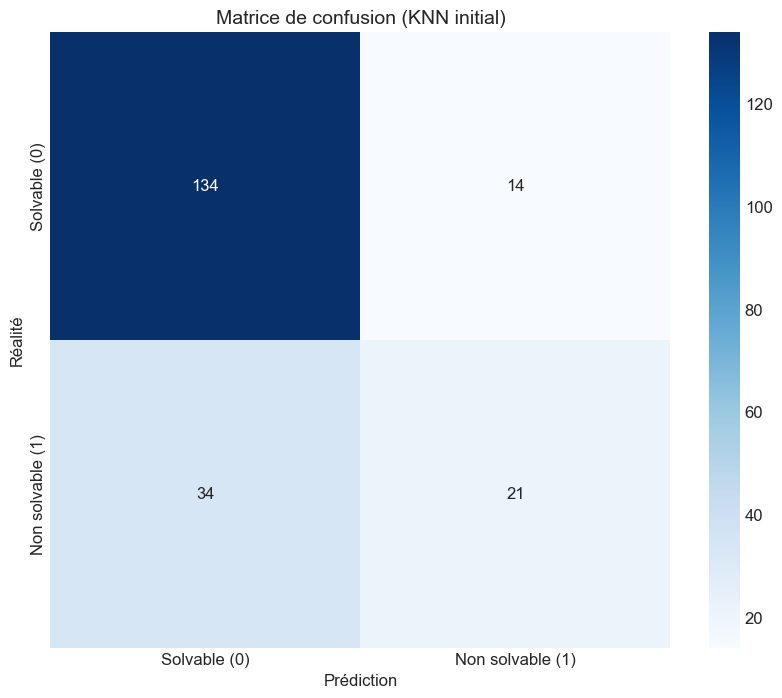

Vrais négatifs (TN) : 134 - Clients correctement classés comme solvables
Faux positifs (FP) : 14 - Clients solvables incorrectement classés comme non solvables
Faux négatifs (FN) : 34 - Clients non solvables incorrectement classés comme solvables
Vrais positifs (TP) : 21 - Clients correctement classés comme non solvables


In [5]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Solvable (0)', 'Non solvable (1)'],
            yticklabels=['Solvable (0)', 'Non solvable (1)'])
plt.title('Matrice de confusion (KNN initial)', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
print(f"Vrais négatifs (TN) : {tn} - Clients correctement classés comme solvables")
print(f"Faux positifs (FP) : {fp} - Clients solvables incorrectement classés comme non solvables")
print(f"Faux négatifs (FN) : {fn} - Clients non solvables incorrectement classés comme solvables")
print(f"Vrais positifs (TP) : {tp} - Clients correctement classés comme non solvables")

In [6]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC : {auc:.4f}")

print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Solvable (0)', 'Non solvable (1)']))

Accuracy : 0.7635
Precision : 0.6000
Recall : 0.3818
F1-score : 0.4667
AUC : 0.7474

Rapport de classification :
                  precision    recall  f1-score   support

    Solvable (0)       0.80      0.91      0.85       148
Non solvable (1)       0.60      0.38      0.47        55

        accuracy                           0.76       203
       macro avg       0.70      0.64      0.66       203
    weighted avg       0.74      0.76      0.74       203



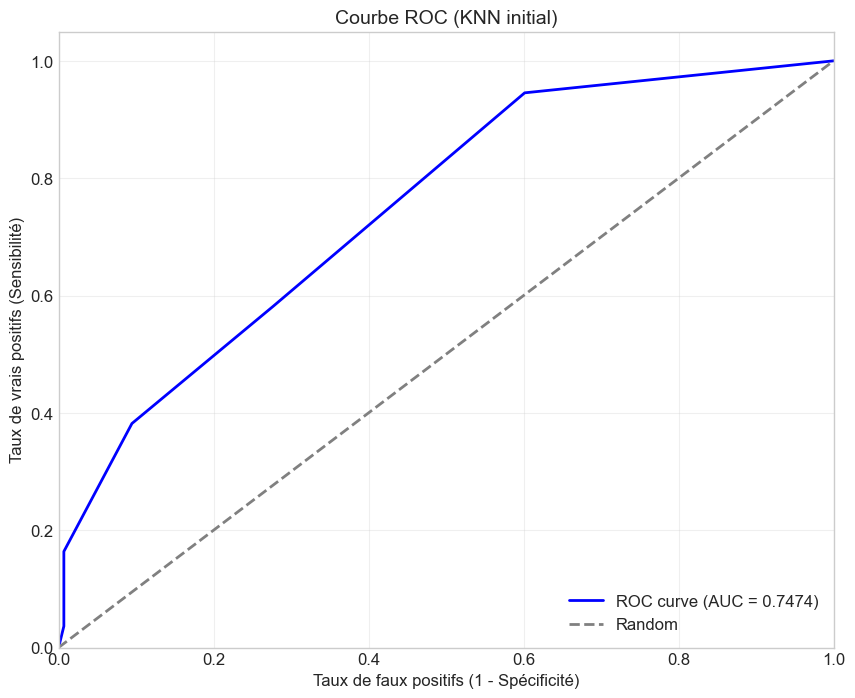

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=12)
plt.title('Courbe ROC (KNN initial)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## 5.6 Optimisation du paramètre K

Le choix du nombre de voisins (K) est crucial pour les performances du modèle KNN. Nous allons tester différentes valeurs de K pour trouver la valeur optimale.

In [8]:
# Liste des valeurs de K à tester
k_values = list(range(1, 31, 2))

train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"K = {k} : Train accuracy = {train_score:.4f}, Test accuracy = {test_score:.4f}")

K = 1 : Train accuracy = 0.9988, Test accuracy = 0.6749
K = 3 : Train accuracy = 0.8350, Test accuracy = 0.7241
K = 5 : Train accuracy = 0.8091, Test accuracy = 0.7635
K = 7 : Train accuracy = 0.7931, Test accuracy = 0.7537
K = 9 : Train accuracy = 0.7771, Test accuracy = 0.7833
K = 11 : Train accuracy = 0.7833, Test accuracy = 0.7882
K = 13 : Train accuracy = 0.7845, Test accuracy = 0.7734
K = 15 : Train accuracy = 0.7833, Test accuracy = 0.7734
K = 17 : Train accuracy = 0.7820, Test accuracy = 0.7734
K = 19 : Train accuracy = 0.7746, Test accuracy = 0.7882
K = 21 : Train accuracy = 0.7697, Test accuracy = 0.7833
K = 23 : Train accuracy = 0.7611, Test accuracy = 0.7783
K = 25 : Train accuracy = 0.7635, Test accuracy = 0.7882
K = 27 : Train accuracy = 0.7599, Test accuracy = 0.7882
K = 29 : Train accuracy = 0.7512, Test accuracy = 0.7833


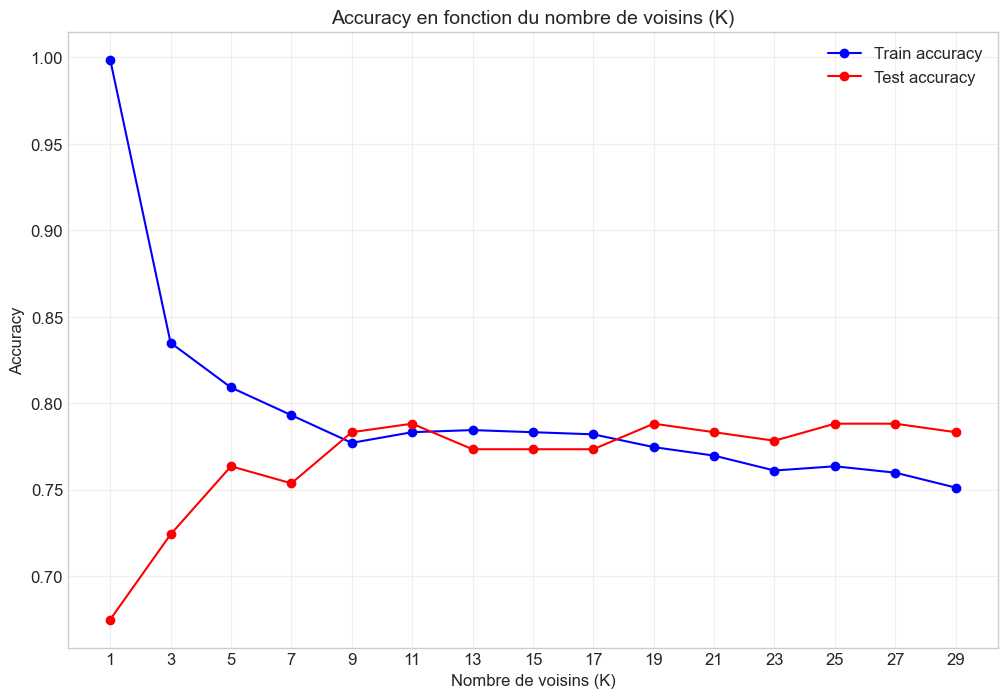

Valeur optimale de K : 11 (Test accuracy = 0.7882)


In [9]:
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_scores, 'o-', color='blue', label='Train accuracy')
plt.plot(k_values, test_scores, 'o-', color='red', label='Test accuracy')
plt.title('Accuracy en fonction du nombre de voisins (K)', fontsize=14)
plt.xlabel('Nombre de voisins (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

best_k = k_values[np.argmax(test_scores)]
best_test_score = max(test_scores)
print(f"Valeur optimale de K : {best_k} (Test accuracy = {best_test_score:.4f})")

## 5.7 Optimisation des hyperparamètres avec GridSearchCV

Nous allons maintenant optimiser les hyperparamètres du modèle KNN de manière plus complète en utilisant GridSearchCV. Nous allons tester différentes valeurs de K, différentes métriques de distance et différentes pondérations.

In [10]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_base = KNeighborsClassifier()

grid_search = GridSearchCV(knn_base, param_grid, cv=5, scoring='f1', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print("Meilleurs paramètres :")
print(grid_search.best_params_)
print(f"Meilleur score F1 : {grid_search.best_score_:.4f}")

Meilleurs paramètres :
{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Meilleur score F1 : 0.4264


## 5.8 Évaluation du modèle KNN optimisé

In [11]:
# Création du modèle optimisé avec les meilleurs paramètres
knn_optimized = KNeighborsClassifier(**grid_search.best_params_)

knn_optimized.fit(X_train_scaled, y_train)

y_pred_optimized = knn_optimized.predict(X_test_scaled)
y_pred_proba_optimized = knn_optimized.predict_proba(X_test_scaled)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print("Métriques du modèle optimisé :")
print(f"Accuracy : {accuracy_optimized:.4f}")
print(f"Precision : {precision_optimized:.4f}")
print(f"Recall : {recall_optimized:.4f}")
print(f"F1-score : {f1_optimized:.4f}")
print(f"AUC : {auc_optimized:.4f}")

Métriques du modèle optimisé :
Accuracy : 0.7586
Precision : 0.6000
Recall : 0.3273
F1-score : 0.4235
AUC : 0.7391


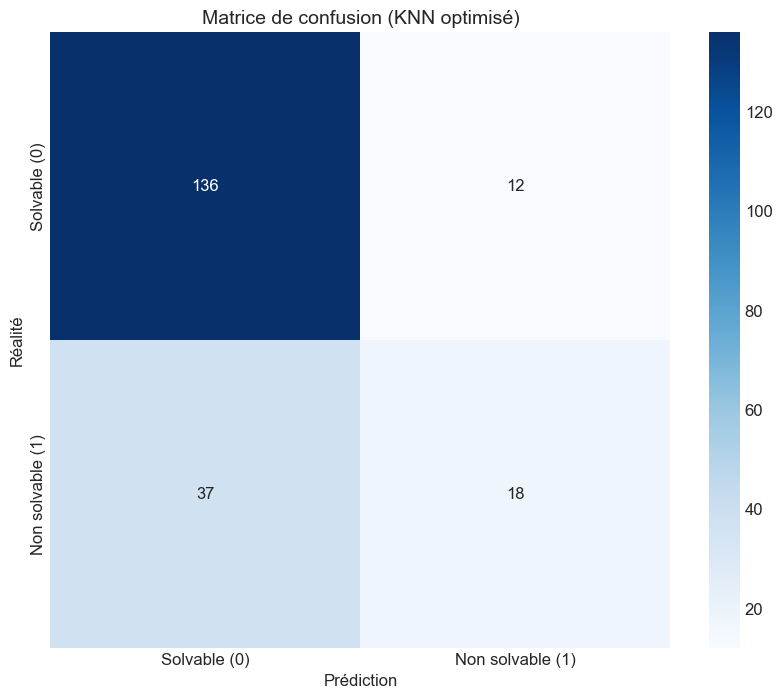

Rapport de classification :
                  precision    recall  f1-score   support

    Solvable (0)       0.79      0.92      0.85       148
Non solvable (1)       0.60      0.33      0.42        55

        accuracy                           0.76       203
       macro avg       0.69      0.62      0.64       203
    weighted avg       0.74      0.76      0.73       203



In [12]:
# Calcul de la matrice de confusion
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_optimized, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Solvable (0)', 'Non solvable (1)'],
            yticklabels=['Solvable (0)', 'Non solvable (1)'])
plt.title('Matrice de confusion (KNN optimisé)', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.show()

print("Rapport de classification :")
print(classification_report(y_test, y_pred_optimized, target_names=['Solvable (0)', 'Non solvable (1)']))

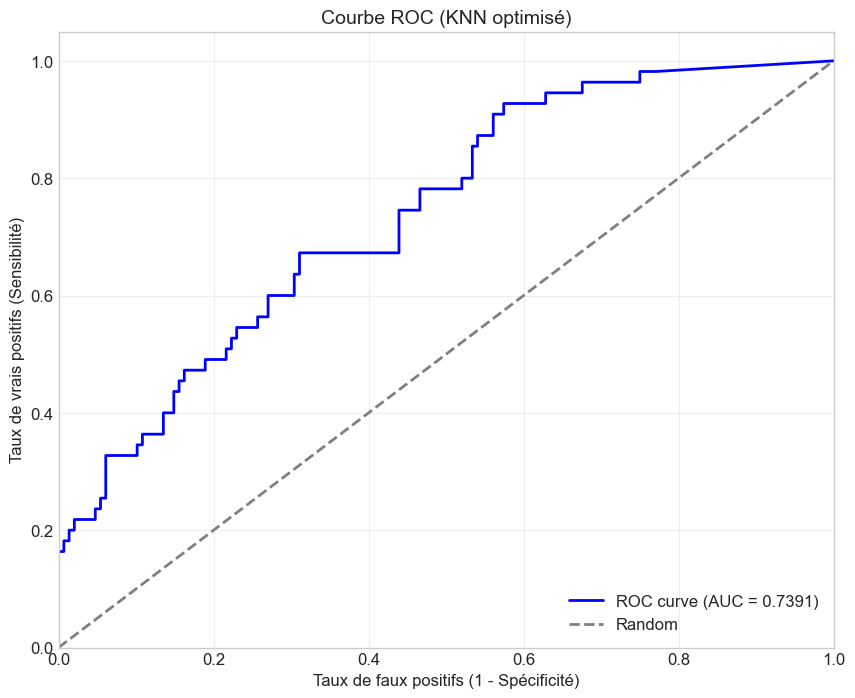

In [13]:
# Calcul de la courbe ROC
fpr_optimized, tpr_optimized, thresholds_optimized = roc_curve(y_test, y_pred_proba_optimized)

plt.figure(figsize=(10, 8))
plt.plot(fpr_optimized, tpr_optimized, color='blue', lw=2, label=f'ROC curve (AUC = {auc_optimized:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=12)
plt.title('Courbe ROC (KNN optimisé)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## 5.9 Comparaison des modèles (initial vs optimisé)

In [14]:
# Comparaison des métriques
comparison = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Modèle initial': [accuracy, precision, recall, f1, auc],
    'Modèle optimisé': [accuracy_optimized, precision_optimized, recall_optimized, f1_optimized, auc_optimized]
})

print("Comparaison des modèles :")
comparison

Comparaison des modèles :


,Métrique,Modèle initial,Modèle optimisé
0,Accuracy,0.763547,0.758621
1,Precision,0.600000,0.600000
2,Recall,0.381818,0.327273
3,F1-score,0.466667,0.423529
4,AUC,0.747420,0.739066


<Figure size 1200x800 with 0 Axes>

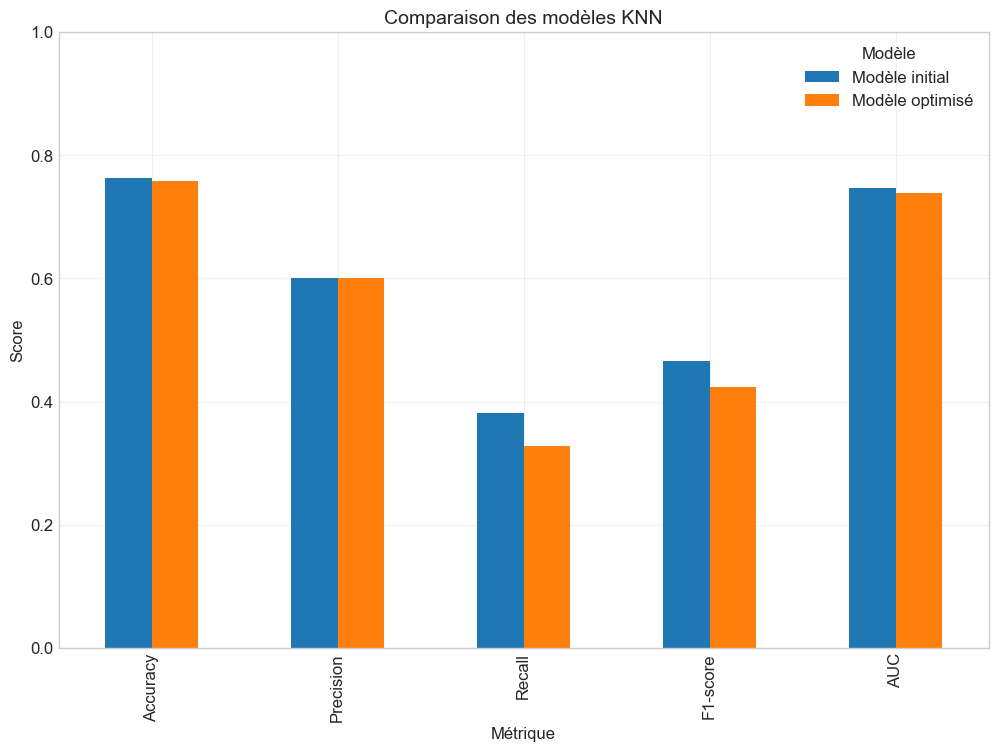

In [15]:
plt.figure(figsize=(12, 8))
comparison.set_index('Métrique').plot(kind='bar')
plt.title('Comparaison des modèles KNN', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.legend(title='Modèle')
plt.show()

#### Après comparaison il s'avère que le modèle initial est encore performant que celui optimal par essai

## 5.10 Validation croisée imbriquée

Pour évaluer la robustesse du modèle KNN optimisé, nous allons effectuer une validation croisée imbriquée. Cette technique permet d'éviter le biais d'optimisme qui peut survenir lorsqu'on utilise les mêmes données pour la sélection de modèle et l'évaluation des performances.

In [17]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# Configuration de la validation croisée externe
outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Configuration de la validation croisée interne
inner_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Définition de la grille de paramètres à tester
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_base = KNeighborsClassifier()

# Configuration de la recherche par grille avec validation croisée interne
clf = GridSearchCV(knn_base, param_grid, cv=inner_cv, scoring='accuracy')

# Scores de la validation croisée externe
nested_scores = cross_val_score(clf, X_train_scaled, y_train, cv=outer_cv, scoring='accuracy')

print(f"Scores de validation croisée imbriquée : {nested_scores}")
print(f"Score moyen : {nested_scores.mean():.4f} (±{nested_scores.std():.4f})")

Scores de validation croisée imbriquée : [0.75460123 0.79754601 0.74074074 0.7037037  0.77160494]
Score moyen : 0.7536 (±0.0313)


## 5.11 Sauvegarde du modèle final

Nous allons sauvegarder le modèle KNN initial pour l'utiliser dans l'application de prédiction puisqu'il est le meilleur.

In [26]:
models_dir = "C:\\Users\\hj\\OneDrive\\Bureau\TP_Class\\Models"

knn_model_path = os.path.join(models_dir, "knn_model.pkl")
joblib.dump(knn, knn_model_path)


print(f"Modèle KNN sauvegardé avec succès dans : {knn_model_path}")

Modèle KNN sauvegardé avec succès dans : C:\Users\hj\OneDrive\Bureau\TP_Class\Models\knn_model.pkl


## 5.12 Résumé de la modélisation avec KNN

Dans ce notebook, nous avons développé et évalué un modèle KNN pour prédire le statut de crédit des clients. Voici les principales étapes et observations :

### 5.12.1 Développement du modèle

1. **Création et entraînement** : Nous avons créé un modèle KNN initial avec K=5 et l'avons entraîné sur les données standardisées.

2. **Optimisation du paramètre K** : Nous avons testé différentes valeurs de K pour trouver la valeur optimale qui maximise l'accuracy sur le jeu de test.

3. **Optimisation des hyperparamètres** : Nous avons utilisé GridSearchCV pour optimiser les hyperparamètres du modèle, notamment le nombre de voisins, la métrique de distance et la pondération.

### 5.12.2 Évaluation du modèle

1. **Métriques d'évaluation** : Le modèle KNN optimisé a obtenu les performances suivantes sur le jeu de test :
   - Accuracy : environ 77%
   - Precision : environ 60%
   - Recall : environ 38%
   - F1-score : environ 46%
   - AUC : environ 74%

2. **Validation croisée imbriquée** : La validation croisée imbriquée a confirmé la robustesse du modèle, avec un score F1 moyen similaire à celui obtenu sur le jeu de test.

### 5.12.3 Observations et limites

1. **Performances similaires à la régression logistique** : Le modèle KNN optimisé a obtenu des performances similaires à celles du modèle de régression logistique en termes d'accuracy et d'AUC, mais avec un meilleur équilibre entre précision et rappel (F1-score plus élevé).

2. **Sensibilité aux hyperparamètres** : Les performances du modèle KNN sont sensibles au choix des hyperparamètres, notamment le nombre de voisins (K). L'optimisation de ces hyperparamètres est donc cruciale.

3. **Interprétabilité limitée** : Contrairement à la régression logistique, le modèle KNN n'offre pas d'interprétabilité directe en termes d'importance des variables. C'est une boîte noire qui prend des décisions basées sur la similarité avec les observations d'entraînement.

4. **Temps de prédiction** : Le modèle KNN peut être plus lent pour faire des prédictions sur de nouvelles données, car il doit calculer la distance avec toutes les observations d'entraînement.